In [1]:
#importing packages
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','sri','lanka','lankan'])

In [3]:
df = pd.read_excel('/Users/Suwani/Desktop/Moodys Project/Cleaned data/nov19_cleaned.xlsx')

In [4]:
df.head()

,Headline,Date,Year,Month,Day
0,Canada announces $2 million support for landmi...,2019-11-30 00:00:00,2019,11,30
1,13 Sri Lankan fishermen arrested in Maldives,2019-11-30 00:00:00,2019,11,30
2,4 reforms to uplift Sri Lankan Rugby,2019-11-29 00:00:00,2019,11,29
3,More than 50% of all foreign military training...,2019-11-27 00:00:00,2019,11,27
4,Sri Lanka 4th best country to travel in 2019-C...,2019-11-27 00:00:00,2019,11,27


In [5]:
# Convert to list
data = df.Headline.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [6]:
pprint(data[:1])

['Canada announces $2 million support for landmine clearance in Northern Sri '
 'Lanka']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['canada', 'announces', 'million', 'support', 'for', 'landmine', 'clearance', 'in', 'northern', 'sri', 'lanka']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['canada', 'announces', 'million', 'support', 'for', 'landmine', 'clearance', 'in', 'northern', 'sri', 'lanka']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['canada', 'announce', 'support', 'landmine', 'clearance', 'northern', 'lanka']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"india" + 0.026*"ahead" + 0.025*"global" + 0.023*"security" + '
  '0.022*"national" + 0.020*"finance" + 0.016*"issue" + 0.014*"final" + '
  '0.014*"slpp" + 0.012*"attack"'),
 (1,
  '0.034*"sajith" + 0.029*"hold" + 0.027*"visit" + 0.024*"month" + '
  '0.023*"pledge" + 0.017*"party" + 0.015*"air" + 0.014*"mcc" + '
  '0.014*"colombo" + 0.013*"make"'),
 (2,
  '0.046*"bank" + 0.023*"step" + 0.019*"lanka" + 0.015*"leave" + 0.015*"dec" + '
  '0.015*"update" + 0.012*"service" + 0.011*"police" + 0.010*"race" + '
  '0.010*"extend"'),
 (3,
  '0.082*"lanka" + 0.046*"president" + 0.043*"rajapaksa" + 0.037*"lankan" + '
  '0.034*"new" + 0.031*"presidential" + 0.022*"pm" + 0.021*"win" + '
  '0.018*"gotabaya" + 0.015*"award"'),
 (4,
  '0.072*"low" + 0.045*"cut" + 0.023*"deliver" + 0.023*"lower" + '
  '0.016*"politician" + 0.012*"former" + 0.011*"sovereign" + 0.011*"rating" + '
  '0.011*"negative" + 0.011*"moodys"'),
 (5,
  '0.077*"poll" + 0.071*"rupee" + 0.048*"share" + 0.045*"end" + 0.02

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.519452227285734

Coherence Score:  0.5932800375890129


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.356859  0.038677       1        1  24.767467
5     -0.090511  0.294565       2        1  10.317005
0     -0.069915 -0.048834       3        1  10.111553
7     -0.063203 -0.049310       4        1   9.503016
9      0.032530 -0.023218       5        1   9.245228
6     -0.026214 -0.066780       6        1   9.019043
1     -0.060445 -0.047928       7        1   8.838500
2     -0.012298 -0.025477       8        1   8.271675
8     -0.019376 -0.045542       9        1   6.320052
4     -0.047427 -0.026154      10        1   3.606465, topic_info=     Category        Freq          Term       Total  loglift  logprob
4     Default  164.000000         lanka  164.000000  30.0000  30.0000
757   Default   52.000000          poll   52.000000  29.0000  29.0000
2676  Default   49.000000         rupee   49.000000  28.0000  28.0000
75    Default   76.000000     president   76.000000  27.0000  27.0000
61    Default   70.000000     rajapaksa   70.000000  26.0000  26.0000
169   Default   38.000000         india   38.000000  25.0000  25.0000
9     Default   82.000000        lankan   82.000000  24.0000  24.0000
1339  Default   33.000000         share   33.000000  23.0000  23.0000
109   Default   30.000000      election   30.000000  22.0000  22.0000
324   Default   31.000000           end   31.000000  21.0000  21.0000
17    Default   28.000000          high   28.000000  20.0000  20.0000
605   Default   52.000000  presidential   52.000000  19.0000  19.0000
1056  Default   25.000000          bank   25.000000  18.0000  18.0000
1932  Default   27.000000          rate   27.000000  17.0000  17.0000
73    Default   59.000000           new   59.000000  16.0000  16.0000
2523  Default   17.000000           low   17.000000  15.0000  15.0000
39    Default   24.000000       central   24.000000  14.0000  14.0000
229   Default   21.000000         china   21.000000  13.0000  13.0000
1737  Default   21.000000          govt   21.000000  12.0000  12.0000
106   Default   20.000000        sajith   20.000000  11.0000  11.0000
738   Default   36.000000            pm   36.000000  10.0000  10.0000
458   Default   18.000000        policy   18.000000   9.0000   9.0000
1169  Default   18.000000          gota   18.000000   8.0000   8.0000
413   Default   34.000000           win   34.000000   7.0000   7.0000
291   Default   17.000000          hold   17.000000   6.0000   6.0000
539   Default   17.000000         ahead   17.000000   5.0000   5.0000
1990  Default   11.000000           cut   11.000000   4.0000   4.0000
296   Default   17.000000        global   17.000000   3.0000   3.0000
454   Default   16.000000         visit   16.000000   2.0000   2.0000
58    Default   13.000000       mahinda   13.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
2708  Topic10    5.438862         lower    6.057172   3.2148  -3.7818
2706  Topic10    5.438862       deliver    6.057172   3.2148  -3.7818
147   Topic10    3.912508    politician    4.530859   3.1757  -4.1112
242   Topic10    2.908868        former    3.527054   3.1297  -4.4076
2692  Topic10    2.739568        rating    3.357843   3.1189  -4.4676
2690  Topic10    2.739568        moodys    3.357843   3.1189  -4.4676
2691  Topic10    2.739568      negative    3.357843   3.1189  -4.4676
2693  Topic10    2.739568     sovereign    3.357843   3.1189  -4.4676
2707  Topic10    2.739293       graphic    3.357681   3.1189  -4.4677
1223  Topic10    2.346424         local    2.964743   3.0885  -4.6225
964   Topic10    2.129012           tax    2.747197   3.0675  -4.7198
1257  Topic10    2.123553     jayaratne    2.741708   3.0670  -4.7223
246   Topic10    1.969534          star    2.587690   3.0495  -4.7976
1660  Topic10    1.836976         lease    2.455165   3.0324  -4.8673
467   Topic10    1.674459          play    2.292649   3.0082  -4.9599
1566  Topic10    1.

In [16]:
mallet_path = '/Users/Suwani/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)


In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('president', 0.1430817610062893),
   ('rajapaksa', 0.07861635220125786),
   ('gotabaya', 0.0660377358490566),
   ('congratulate', 0.029874213836477988),
   ('elect', 0.01729559748427673),
   ('victory', 0.01729559748427673),
   ('modi', 0.012578616352201259),
   ('combank', 0.0110062893081761),
   ('key', 0.009433962264150943),
   ('centre', 0.009433962264150943)]),
 (1,
  [('lanka', 0.16429699842022116),
   ('good', 0.017377567140600316),
   ('final', 0.017377567140600316),
   ('governor', 0.014218009478672985),
   ('army', 0.014218009478672985),
   ('swear', 0.014218009478672985),
   ('country', 0.014218009478672985),
   ('clinch', 0.01263823064770932),
   ('culinary', 0.011058451816745656),
   ('brother', 0.011058451816745656)]),
 (2,
  [('gota', 0.05067567567567568),
   ('mcc', 0.02702702702702703),
   ('security', 0.02533783783783784),
   ('receive', 0.02364864864864865),
   ('lead', 0.02027027027027027),
   ('call', 0.02027027027027027),
   ('face', 0.016891891891891893)

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


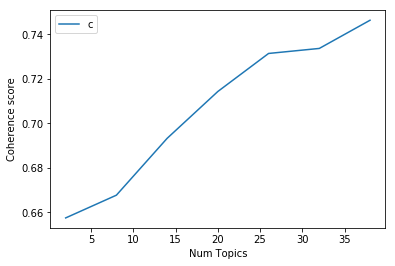

In [20]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.6575
Num Topics = 8  has Coherence Value of 0.6677
Num Topics = 14  has Coherence Value of 0.6932
Num Topics = 20  has Coherence Value of 0.7143
Num Topics = 26  has Coherence Value of 0.7314
Num Topics = 32  has Coherence Value of 0.7337
Num Topics = 38  has Coherence Value of 0.7463


In [22]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

[(0,
  '0.194*"lanka" + 0.033*"gota" + 0.025*"partner" + 0.017*"receive" + '
  '0.015*"finance" + 0.014*"top" + 0.012*"rate" + 0.011*"wtm" + 0.011*"army" + '
  '0.010*"title"'),
 (1,
  '0.034*"poll" + 0.022*"mcc" + 0.022*"sl" + 0.015*"meet" + '
  '0.014*"citizenship" + 0.012*"step" + 0.012*"project" + 0.012*"challenge" + '
  '0.011*"ec" + 0.011*"bank"'),
 (2,
  '0.106*"president" + 0.061*"rajapaksa" + 0.051*"gotabaya" + 0.033*"pm" + '
  '0.023*"congratulate" + 0.018*"visit" + 0.017*"mahinda" + 0.015*"victory" + '
  '0.013*"elect" + 0.013*"tourism"'),
 (3,
  '0.073*"lankan" + 0.028*"year" + 0.025*"high" + 0.020*"security" + '
  '0.020*"day" + 0.019*"end" + 0.015*"share" + 0.015*"policy" + 0.015*"rupee" '
  '+ 0.014*"pledge"'),
 (4,
  '0.034*"sajith" + 0.030*"presidential" + 0.029*"election" + 0.025*"open" + '
  '0.020*"hold" + 0.018*"minister" + 0.016*"global" + 0.014*"lead" + '
  '0.014*"slpp" + 0.014*"issue"'),
 (5,
  '0.052*"win" + 0.027*"good" + 0.025*"launch" + 0.023*"support" + '


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1603,"poll, mcc, sl, meet, citizenship, step, projec...",Canada announces $2 million support for landmi...
1,1,3.0,0.1528,"lankan, year, high, security, day, end, share,...",13 Sri Lankan fishermen arrested in Maldives
2,2,6.0,0.1548,"lanka, award, national, foreign, tamil, centra...",4 reforms to uplift Sri Lankan Rugby
3,3,6.0,0.1468,"lanka, award, national, foreign, tamil, centra...",More than 50% of all foreign military training...
4,4,0.0,0.1525,"lanka, gota, partner, receive, finance, top, r...",Sri Lanka 4th best country to travel in 2019-C...
5,5,1.0,0.1557,"poll, mcc, sl, meet, citizenship, step, projec...",Sri Lanka Rugby rolls out Blue card for Club R...
6,6,7.0,0.1451,"colombo, india, today, china, vote, make, asia...",MCC agreement will be soon launched in Sri Lan...
7,7,6.0,0.1403,"lanka, award, national, foreign, tamil, centra...",200 year old human skulls make their way back ...
8,8,2.0,0.1500,"president, rajapaksa, gotabaya, pm, congratula...",Mahinda Rajapaksa: 24th Prime Minister of Sri ...
9,9,0.0,0.1520,"lanka, gota, partner, receive, finance, top, r...",50% of children in Sri Lanka suffers from Vita...


In [24]:
df_dominant_topic.to_excel('/Users/Suwani/Desktop/Moodys Project/Topid data/Nov_19_T.xlsx')